# Zooplankton Generation time

### Here we want to find the generation time for each of the phytoplankton and the zooplankton to make sure that is within the limits that we expect. We expect microzooplankton to have a lifespan of days to a few weeks, while mesozooplankton of months to a year. Picoplankton to range about a day. We want to do this by divide the Production of each zooplankton divided by their biomass, which would lead to generation time. 

In [2]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Input file with output parameters

In [5]:
## Gaby's Path
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

# path 
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [6]:
print('What is the file you want to comapre with? (new_file)?')
new_file = input('')
print('What year is the new_file? (year)')
new_year = input('')

What is the file you want to comapre with? (new_file)?


 GNG595


What year is the new_file? (year)


 20yrclim


In [7]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr_GNG595_*', recursive=True),
                      key=numericalSort)

In [8]:
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Zooplankton Biomass 

In [9]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names]
phyBmss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol
phyBmss = phyBmss.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2
#phyBmss = (phyBmss* ds.TAREA / 1e4) # mmol C
phyBmss = phyBmss.mean(dim='time') # mmol C m-2

In [10]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = [''+v+'C' for v in zoo_names]
zooBmss = xr.concat([ds[v] for v in zoo_vars], dim='var') # units are mmol
zooBmss = zooBmss.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2
#zooBmss = (zooBmss* ds.TAREA / 1e4) # mmol C m-2
#zooBmss = zooBmss.mean(dim='time') # mmol C m-2

In [11]:
mask_less_than_zero = zooBmss.mean(dim='time').values < 1.06 # find all that are less than zero 
new_zoobmss = zooBmss.mean(dim='time').values
new_zoobmss[mask_less_than_zero] = 0 # Make these values zero

## Zooplankton production

In [13]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = ['x_graze_'+v+'_zint' for v in zoo_names]
zooProd = xr.concat([ds[v] for v in zoo_vars], dim='var') # units are mmol m-3 * cm s-1
zooProd = ((zooProd / 100)) #* ds.TAREA / 1e4) # mmol C s-1 $m^{-2}$
zooProd = zooProd.mean(dim='time') * (60*60*24) # mmol C d-1 $m^{-2}$

## Zooplankton Generation time

In [17]:
zooGen = new_zoobmss/zooProd # mmol $m^{-2}$ C / mmolC $m^{-2}$ d-1 --> d
zooGen_log = np.log10(zooGen)

## Zooplankton Generation times plot

In [18]:
tlon, tlat, zg_zoo1 = adjust_pop_grid(ds.TLONG, ds.TLAT, zooGen[0,:,:])
tlon, tlat, zg_zoo2 = adjust_pop_grid(ds.TLONG, ds.TLAT, zooGen[1,:,:])
tlon, tlat, zg_zoo3 = adjust_pop_grid(ds.TLONG, ds.TLAT, zooGen[2,:,:])
tlon, tlat, zg_zoo4 = adjust_pop_grid(ds.TLONG, ds.TLAT, zooGen[3,:,:])
tlon, tlat, zg_zoo5 = adjust_pop_grid(ds.TLONG, ds.TLAT, zooGen[4,:,:])
tlon, tlat, zg_zoo6 = adjust_pop_grid(ds.TLONG, ds.TLAT, zooGen[5,:,:])

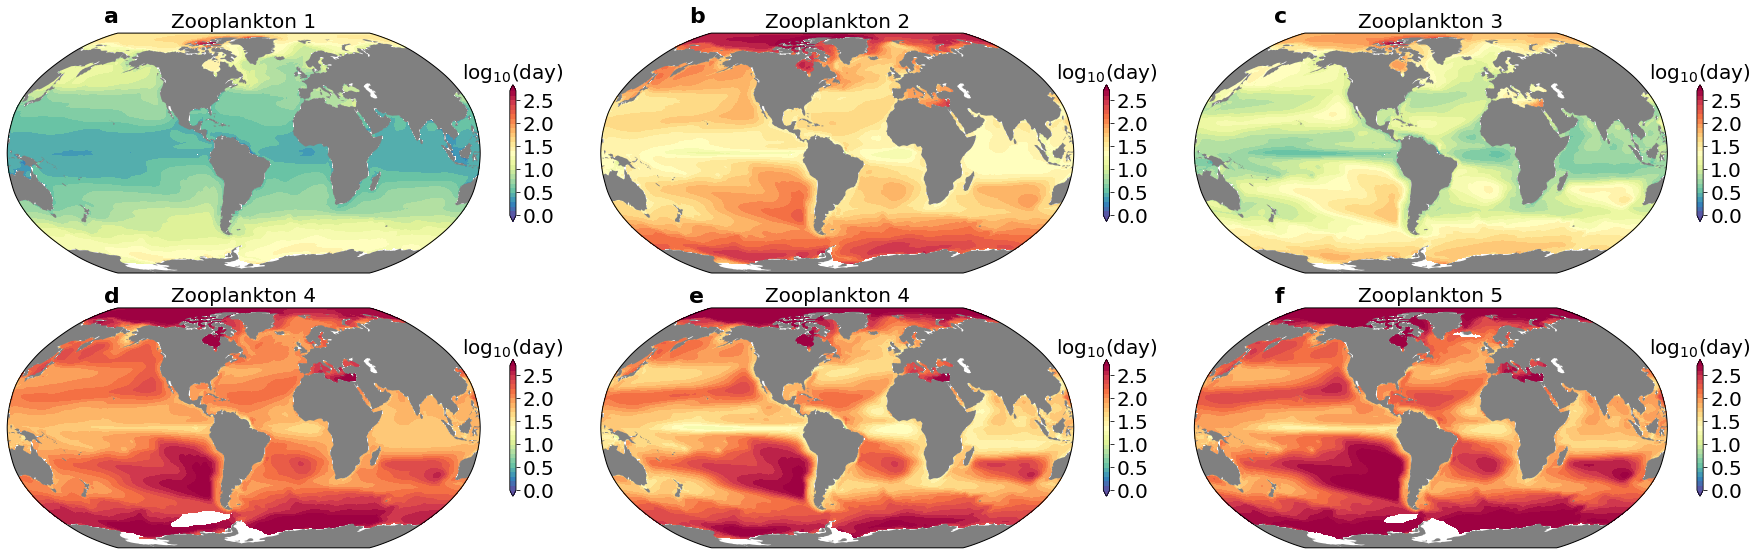

In [19]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(25, 8))
lev = np.arange(0, 2.75, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1.35)
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(tlon, tlat, np.log10(zg_zoo1), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 1', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2,2.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('log$_{10}$(day)', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.06, 0.96, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(tlon, tlat, np.log10(zg_zoo2), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 2', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2,2.5],shrink =0.5,extend = 'both')
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('log$_{10}$(day)', fontsize = 20)
fig.text(0.385, 0.96, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(tlon, tlat, np.log10(zg_zoo3), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 3', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2,2.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('log$_{10}$(day)', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.71, 0.96, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(tlon, tlat, np.log10(zg_zoo4), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 4', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2,2.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('log$_{10}$(day)', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.06, 0.475, 'd',fontsize=22, fontweight='bold')


ax = fig.add_subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(tlon, tlat, np.log10(zg_zoo5), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 4', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2,2.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('log$_{10}$(day)', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.385, 0.475, 'e',fontsize=22, fontweight='bold')


ax = fig.add_subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(tlon, tlat, np.log10(zg_zoo6), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 5', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2,2.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('log$_{10}$(day)', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.71, 0.475, 'f',fontsize=22, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/zoo_gentime_global_log_'+new_file+'_'+new_year+'_year.png',dpi=600, bbox_inches='tight')

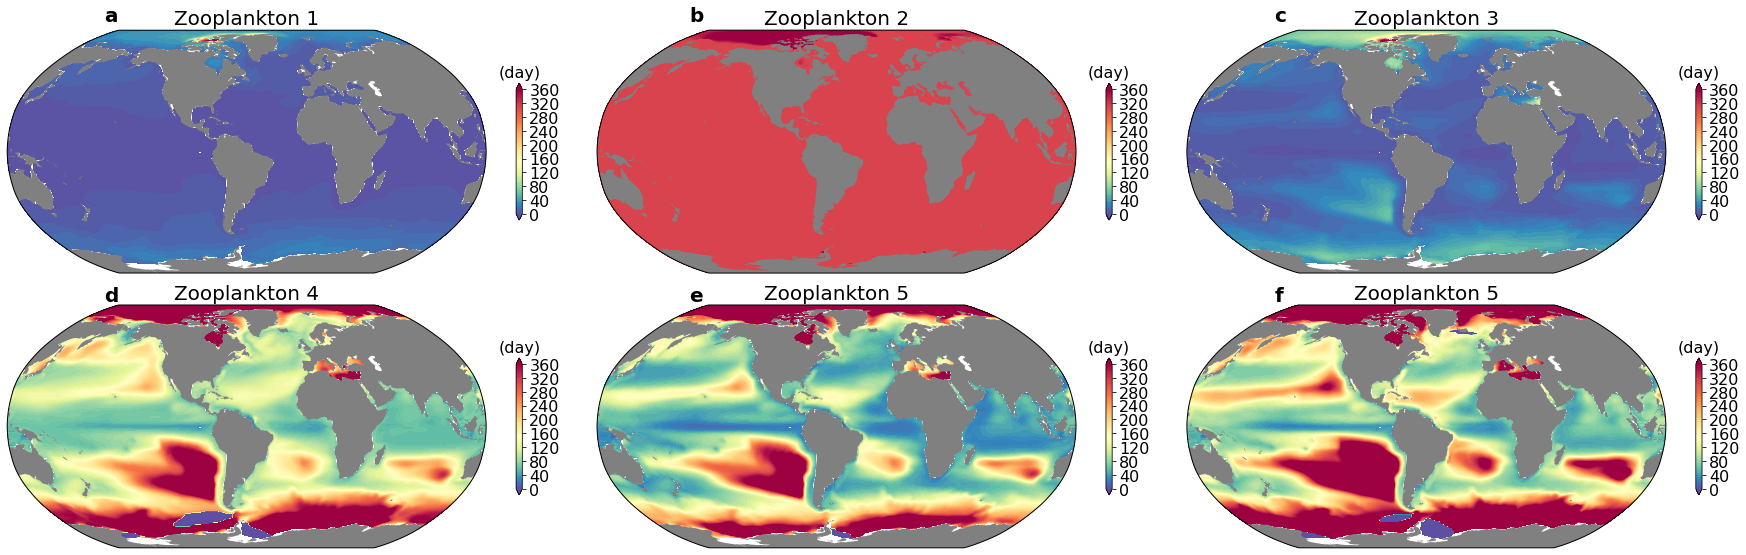

In [20]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(25, 8))
lev = np.arange(0, 365, 5)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=150)
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon, tlat, zg_zoo1, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 1', fontsize = 20)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('(day)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.text(0.06, 0.96, 'a',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon, tlat, zg_zoo2, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 2', fontsize = 20)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('(day)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.text(0.385, 0.96, 'b',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon, tlat, zg_zoo3, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 3', fontsize = 20)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('(day)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.text(0.71, 0.96, 'c',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon, tlat, zg_zoo4, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 4', fontsize = 20)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('(day)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.text(0.06, 0.475, 'd',fontsize=20, fontweight='bold')


ax = fig.add_subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon, tlat, zg_zoo5, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 5', fontsize = 20)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('(day)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.text(0.385, 0.475, 'e',fontsize=20, fontweight='bold')


ax = fig.add_subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(tlon, tlat, zg_zoo6, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 5', fontsize = 20)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('(day)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.text(0.71, 0.475, 'f',fontsize=20, fontweight='bold')
fig.tight_layout()
plt.show()
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/zoo_gentime_global_days_'+new_file+'_'+new_year+'_year.png',dpi=600, bbox_inches='tight')

## Phytoplankton Production 

In [21]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = ['photoC_'+v+'_zint' for v in phyto_names]
phytoProd = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3 * cm s-1
phytoProd = ((phytoProd / 100)) * (60*60*24)# * ds.TAREA / 1e4) # mmol d-1 m-2
#phytoProd = phytoProd.mean(dim='time') # mmol d-1 m-2

## Checking phytoplankton production on december for each phytoplankton type! 

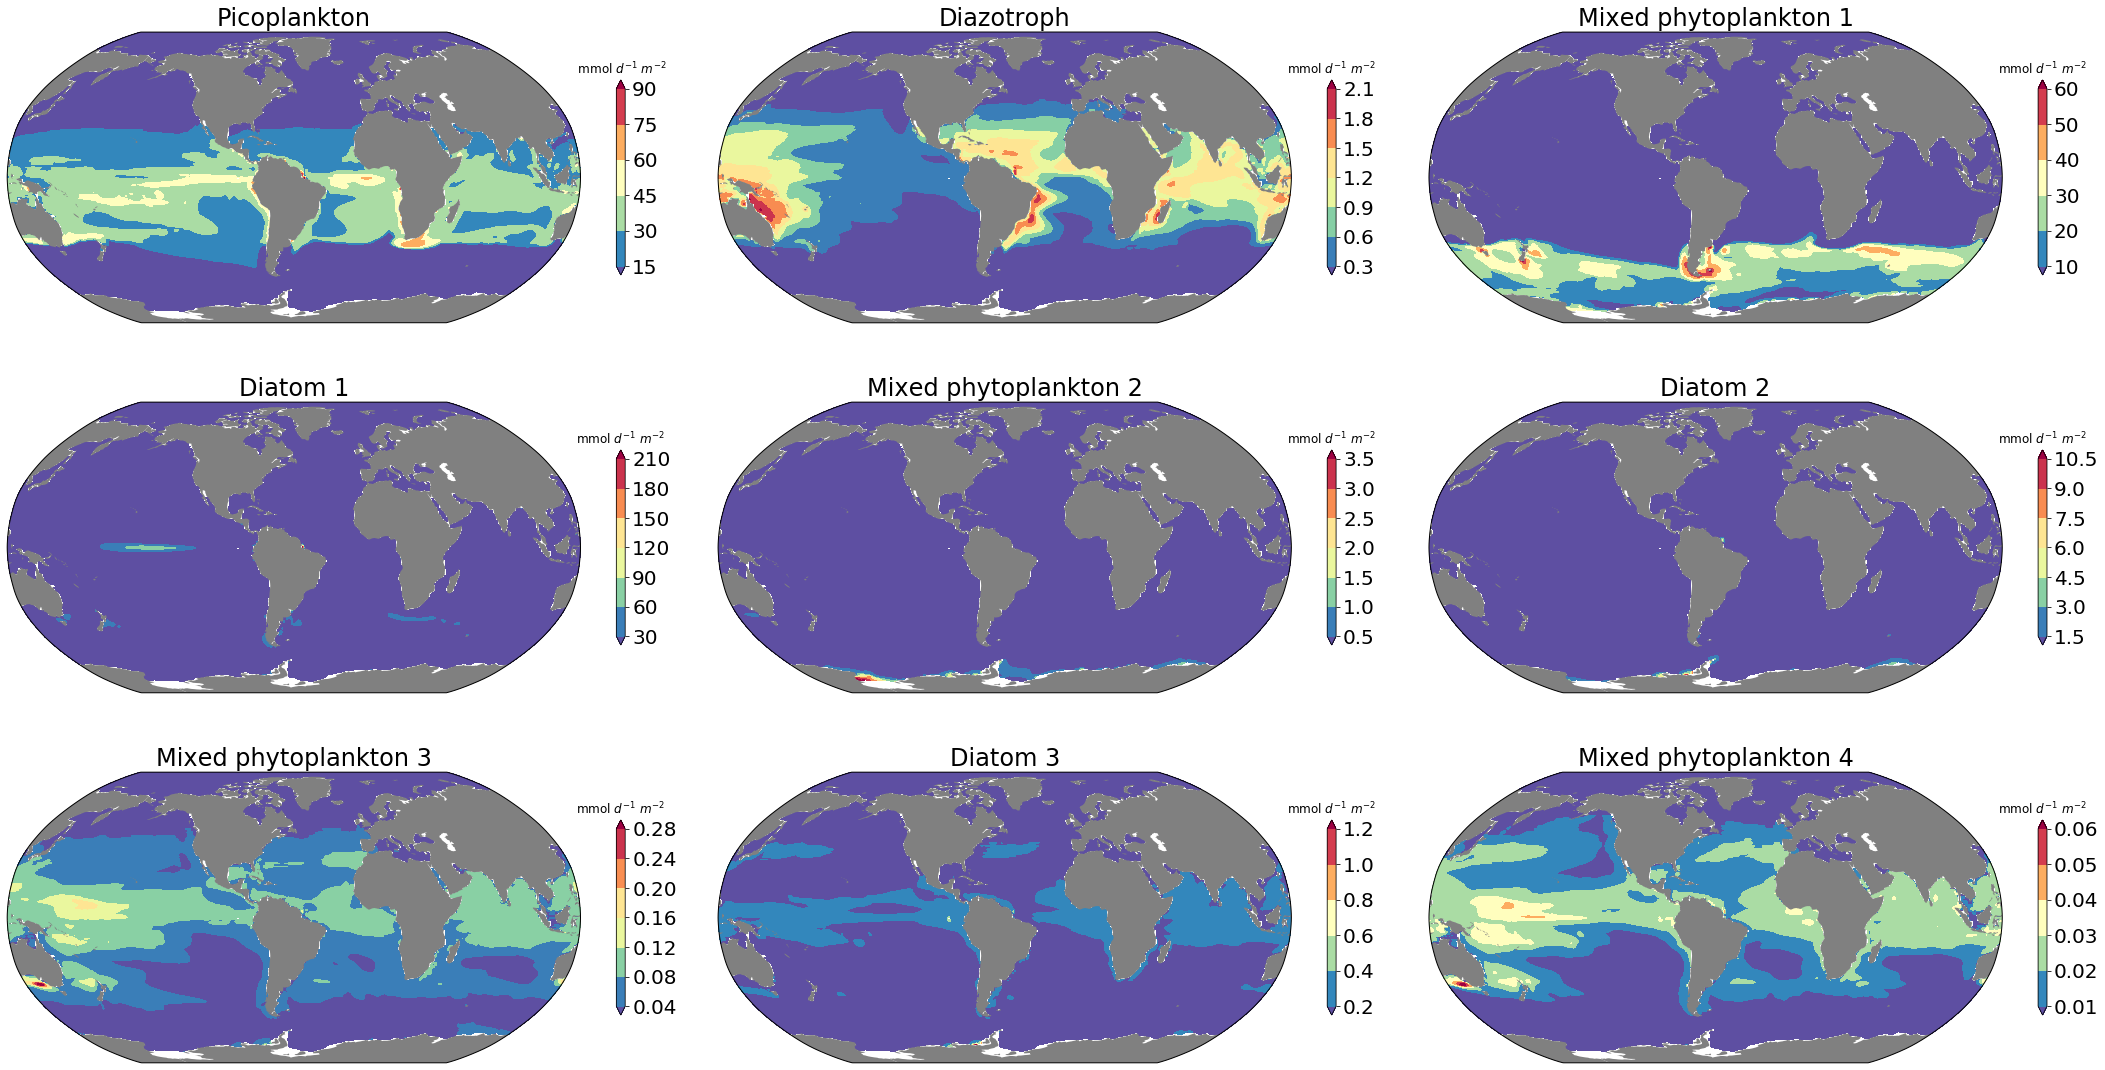

In [22]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[0,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Picoplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title(' mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[1,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diazotroph', fontsize = 24)
ax.set_global()
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[2,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[3,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[4,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)


ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[5,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[6,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[7,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phytoProd[8,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 4', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $d^{-1}$ $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)
fig.tight_layout()
plt.show()

## Phytoplankton Biomass

In [24]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names]
phyBmss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol
phyBmss = phyBmss.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2
#phyBmss = (phyBmss* ds.TAREA / 1e4) # mmol C
#phyBmss = phyBmss.mean(dim='time') # mmolC m-2

## Plot phytoplankton biomass in december

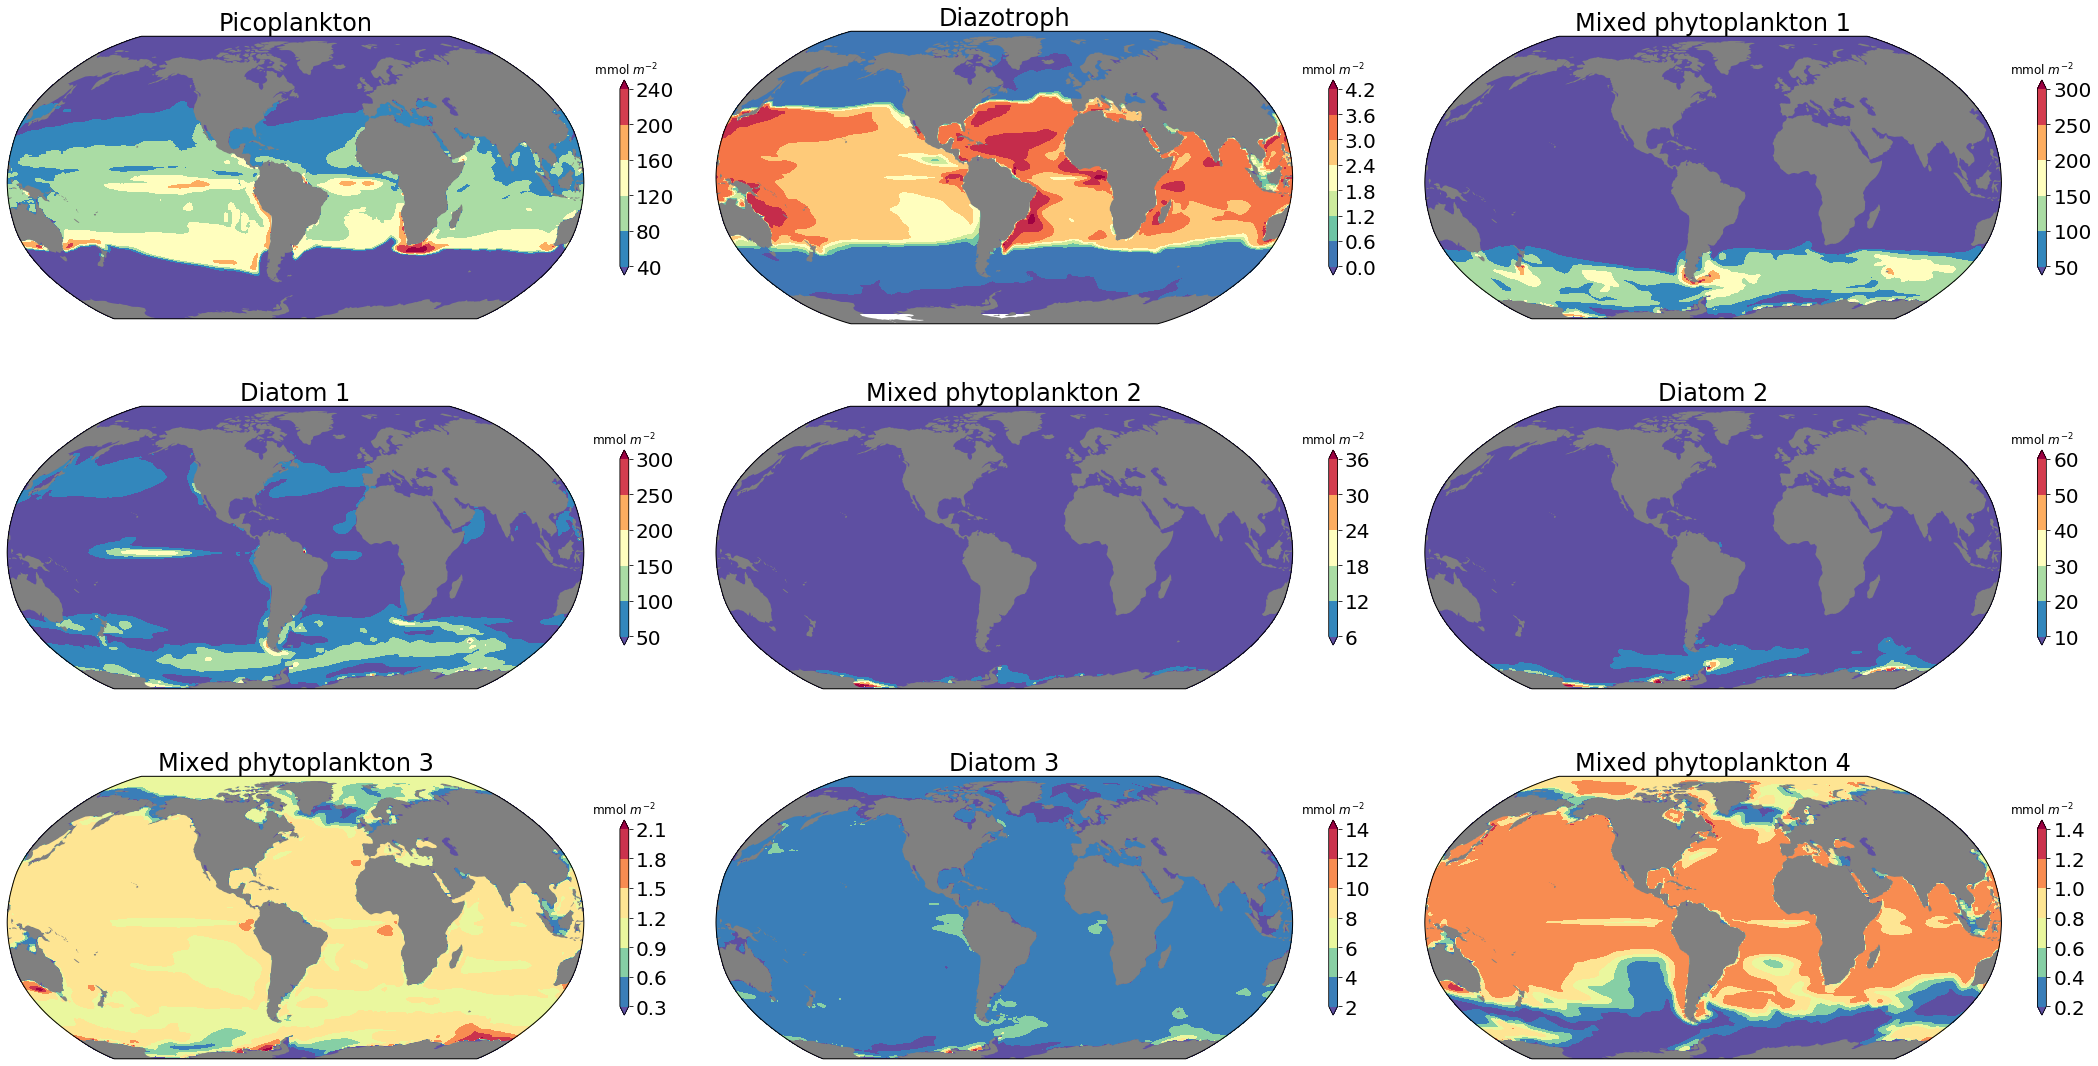

In [25]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[0,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Picoplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title(' mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[1,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diazotroph', fontsize = 24)
ax.set_global()
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[2,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[3,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[4,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)


ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[5,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[6,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[7,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyBmss[8,11,:,:])
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r',extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 4', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmol $m^{-2}$', fontsize = 12)
cbar.ax.tick_params(labelsize=20)
fig.tight_layout()
plt.show()

In [26]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = [''+v+'C' for v in zoo_names]
zooBmss = xr.concat([ds[v] for v in zoo_vars], dim='var') # units are mmol
zooBmss = zooBmss.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2
#zooBmss = zooBmss.mean(dim='time') # mmol C m-2

Text(0.5, 1.0, 'Zooplankton 6 Winter')

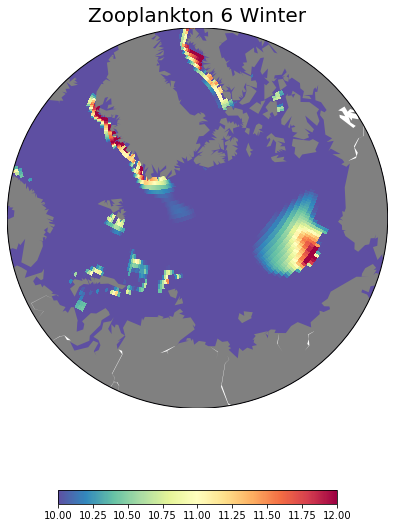

In [27]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, zooBmss[5,11,:,:])
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,summer,cmap='Spectral_r',vmin=10, vmax=12)
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
ax.set_title('Zooplankton 6 Winter', fontsize =20)

In [28]:
mask_less_than_zero = phyBmss.mean(dim='time').values < 1.065 # find all that are less than zero 
new_bmss = phyBmss.mean(dim='time').values
new_bmss[mask_less_than_zero] = 0 # Make these values zero

## Phytoplankton Generation time

In [29]:
phyGen = new_bmss/phytoProd.mean(dim='time') # mmol C / mmolC d-1 --> d
phyGen_log = np.log10(phyGen)

## Phytoplankton generation times plot

In [30]:
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[0,:,:])
x, y, zg_diaz = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[1,:,:])
x, y, zg_mp1 = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[2,:,:])
x, y, zg_mp2 = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[4,:,:])
x, y, zg_mp3 = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[6,:,:])
x, y, zg_mp4 = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[8,:,:])
x, y, zg_diat1 = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[3,:,:])
x, y, zg_diat2 = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[5,:,:])
x, y, zg_diat3 = adjust_pop_grid(ds.TLONG, ds.TLAT, phyGen[7,:,:])

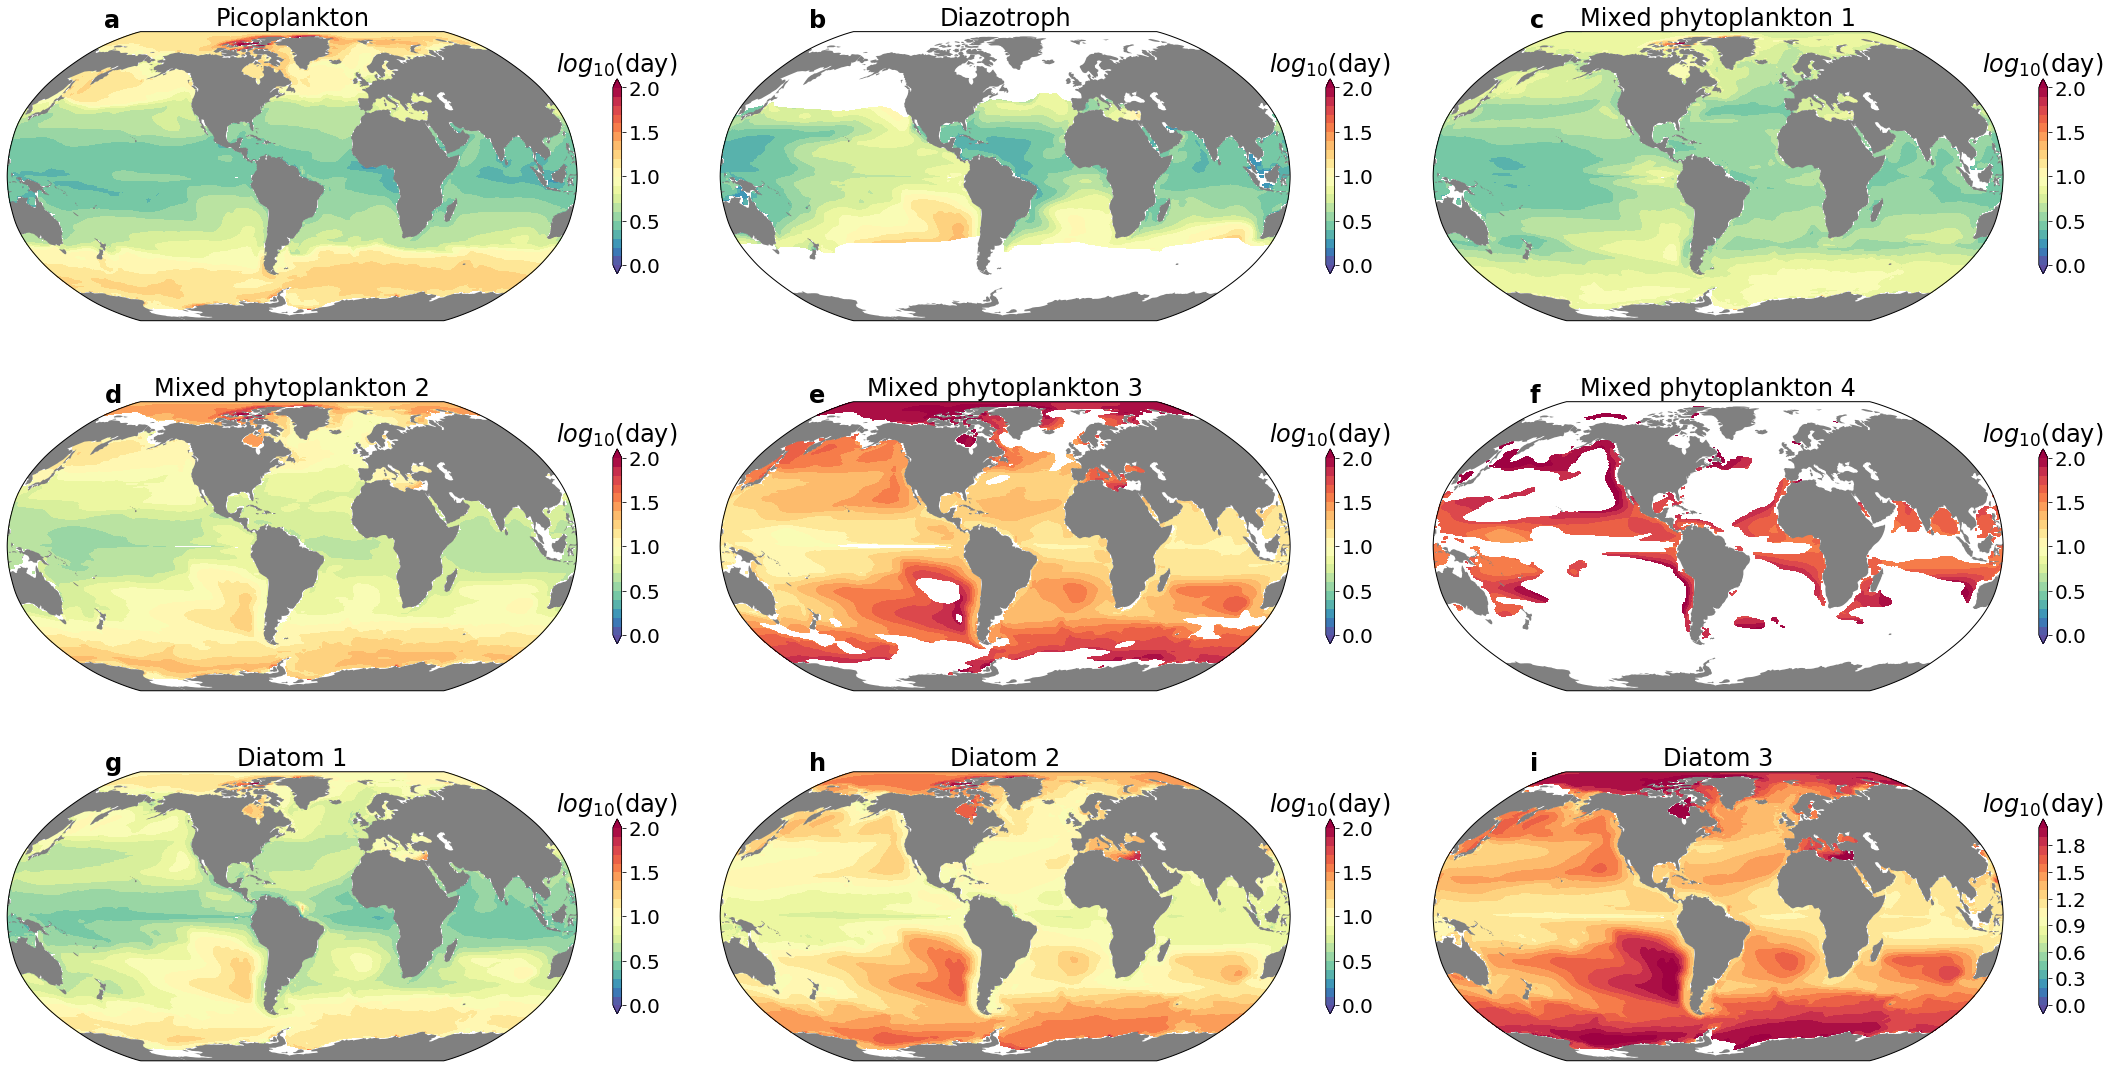

In [31]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 16))
lev = np.arange(0, 2.1, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_pp), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Picoplankton', fontsize = 24)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2],shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_diaz), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diazotroph', fontsize = 24)
ax.set_global()
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2],shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_mp1), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 1', fontsize = 24)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2],shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_mp2), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 2', fontsize = 24)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2],shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_mp3), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 3', fontsize = 24)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2],shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)


ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_mp4), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 4', fontsize = 24)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2],shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_diat1), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 1', fontsize = 24)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2],shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_diat2), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 2', fontsize = 24)
ax.set_global()
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5,2],shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_diat3), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('$log_{10}$(day)', fontsize = 24)
cbar.ax.tick_params(labelsize=20)
fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')
fig.text(0.376, 0.95, 'b',fontsize=24, fontweight='bold')
fig.text(0.71, 0.95, 'c',fontsize=24, fontweight='bold')
fig.text(0.05, 0.625, 'd',fontsize=24, fontweight='bold')
fig.text(0.376, 0.625, 'e',fontsize=24, fontweight='bold')
fig.text(0.71, 0.625, 'f',fontsize=24, fontweight='bold')
fig.text(0.05, 0.305, 'g',fontsize=24, fontweight='bold')
fig.text(0.376, 0.305, 'h',fontsize=24, fontweight='bold')
fig.text(0.71, 0.305, 'i',fontsize=24, fontweight='bold')
fig.tight_layout()
plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/phyto_gentime_global_'+new_file+'_'+new_year+'_year.png',dpi=600, bbox_inches='tight')

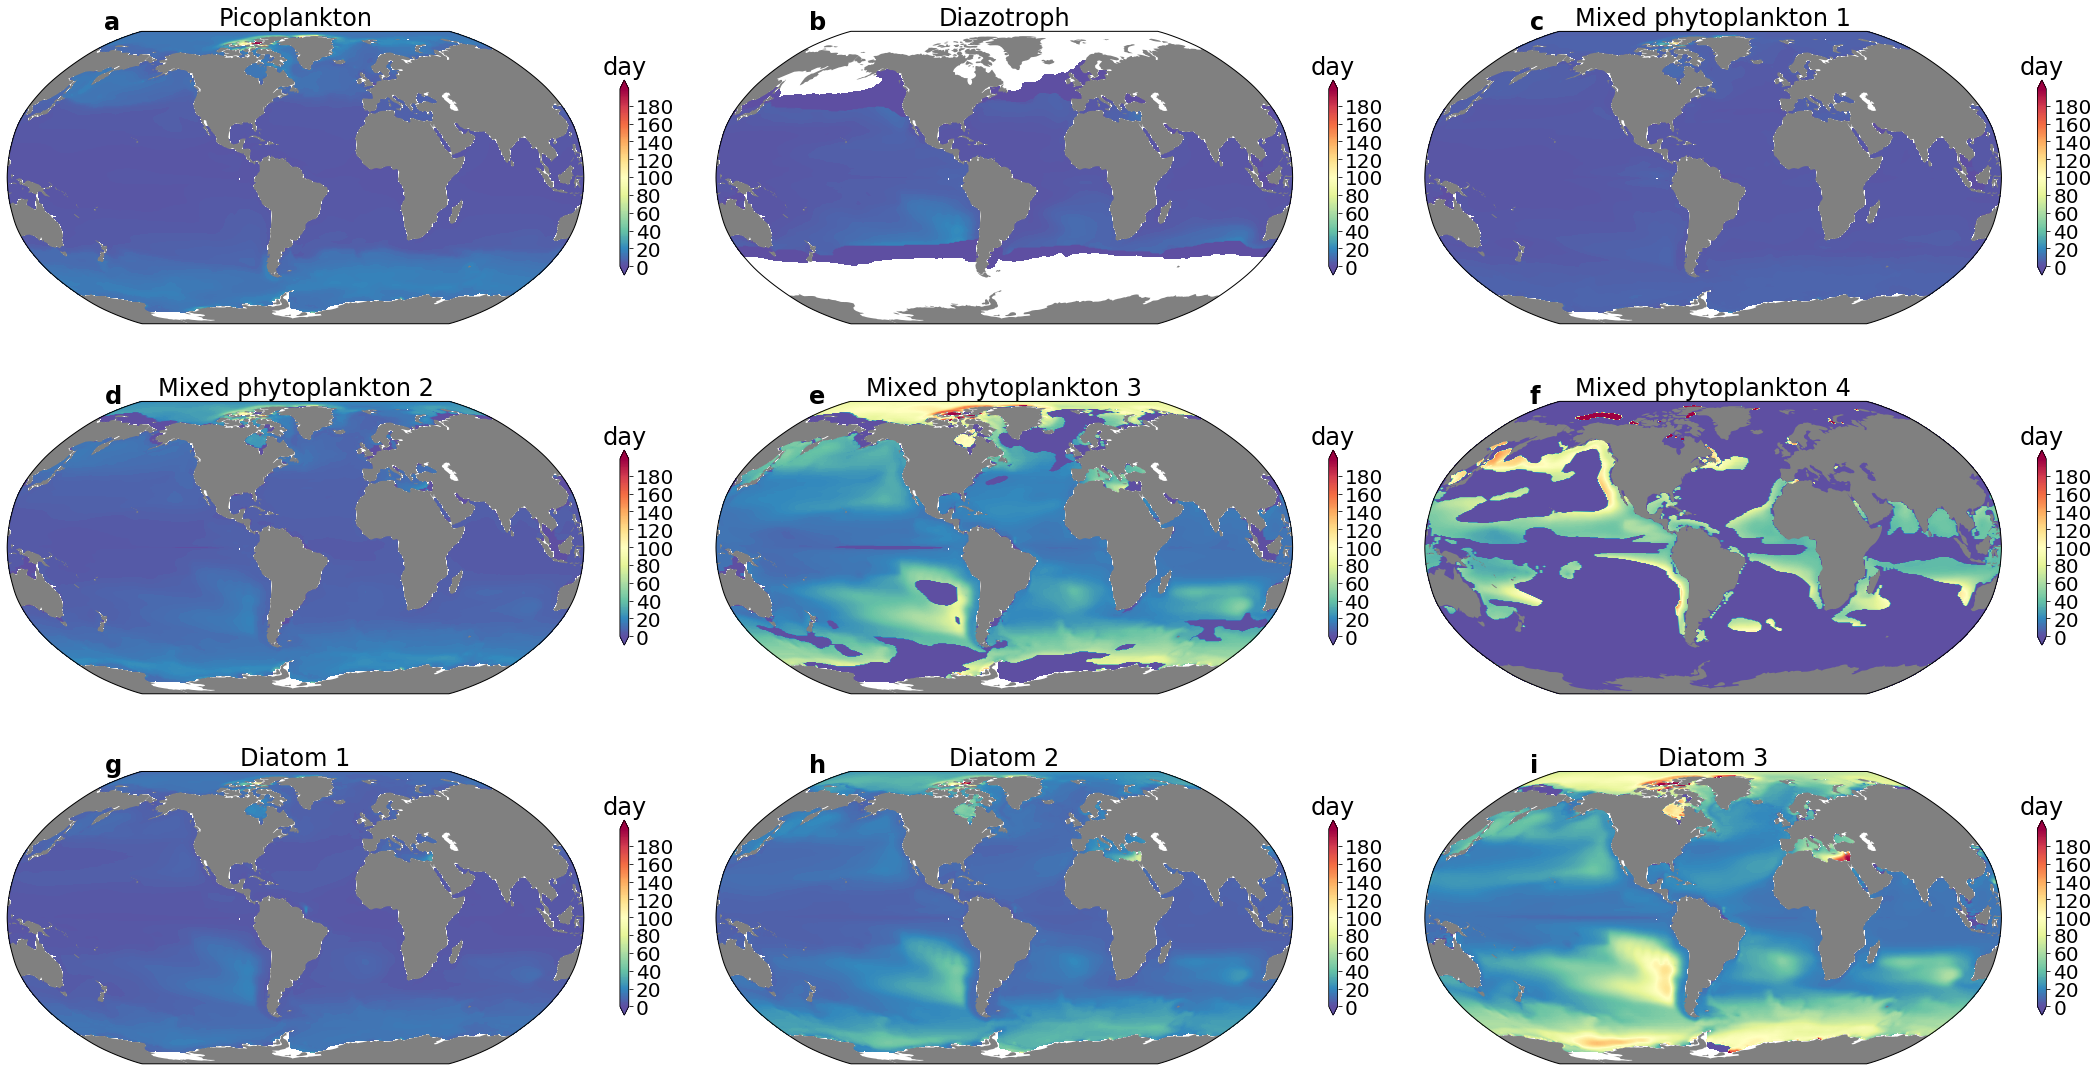

In [32]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 16))
lev = np.arange(0, 200, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=100)
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_pp, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Picoplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_diaz, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diazotroph', fontsize = 24)
ax.set_global()
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_mp1, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_mp2, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_mp3, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_mp4, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 4', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_diat1, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_diat2, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zg_diat3, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('day', fontsize = 24)
cbar.ax.tick_params(labelsize=20)

fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')
fig.text(0.376, 0.95, 'b',fontsize=24, fontweight='bold')
fig.text(0.71, 0.95, 'c',fontsize=24, fontweight='bold')
fig.text(0.05, 0.625, 'd',fontsize=24, fontweight='bold')
fig.text(0.376, 0.625, 'e',fontsize=24, fontweight='bold')
fig.text(0.71, 0.625, 'f',fontsize=24, fontweight='bold')
fig.text(0.05, 0.305, 'g',fontsize=24, fontweight='bold')
fig.text(0.376, 0.305, 'h',fontsize=24, fontweight='bold')
fig.text(0.71, 0.305, 'i',fontsize=24, fontweight='bold')
fig.tight_layout()
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/phyto_gentime_global_day'+new_file+'_'+new_year+'_year.png',dpi=600, bbox_inches='tight')